# How does the taxonomic distribution of contigs differ by soil layer (mineral vs organic) in Colorado?

This notebook uses the existing NMDC-runtime API endpoints (as of December 2023) to explore how the taxononomic distribution of contigs differ by the mineral and organic soil layers in Colorado. It involves 9 API requests to reach the scaffold lineage TSV data objects in order to analyze the taxanomic distribution. Iterating through the TSV files includes 350+ API calls to get the necessary taxonomic counts and is time consuming. The Python library Dill is used to save the state of this Jupyter Notebook session and restore later without having to rerun the cells.

In [1]:
import requests
import pandas as pd
from io import StringIO
import plotly.express as px
import dill
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

## Define a general API call funtion to nmdc-runtime
This function provides a general-purpose way to make an API request to NMDC's runtime API. Note that this function will only return the first page of results. The function's input includes the name of the collection to access (e.g. `biosample_set`), the filter to be performed, the maximum page size, and a list of the fields to be retrieved. It returns the metadata as a json object.

In [2]:
def get_first_page_results(collection: str, filter: str, max_page_size: int, fields: str):
    og_url = f'https://api.microbiomedata.org/nmdcschema/{collection}?&filter={filter}&max_page_size={max_page_size}&projection={fields}'
    resp = requests.get(og_url)
    data = resp.json()
    
    return data

## Define an nmdc-runtime API call function to include pagination
The `get_next_results` function uses the `get_first_page_results` function, defined above, to retrieve the rest of the results from a call with multiple pages. It takes the same inputs as the `get_first_page_results` function above: the name of the collection to be retrieved, the filter string, the maximum page size, and a list of the fields to be returned. This function returns the list of the results. It uses the `next_page_token` key in each page of results to retrieve the following page.

In [3]:
def get_next_results(collection: str, filter: str, max_page_size: int, fields: str):

    # Get initial results (before next_page_token is given in the results)
    result_list = []
    initial_data = get_first_page_results(collection, filter, max_page_size, fields)
    results = initial_data["resources"]
    
    # append first page of results to an empty list
    for result in results:
        result_list.append(result)
    
    # if there are multiple pages of results returned
    if initial_data.get("next_page_token"):
        next_page_token = initial_data["next_page_token"]

        while True:
            url = f'https://api.microbiomedata.org/nmdcschema/{collection}?&filter={filter}&max_page_size={max_page_size}&page_token={next_page_token}&projection={fields}'
            response = requests.get(url)
            data_next = response.json()
            
            results = data_next.get("resources", [])
            result_list.extend(results)
            next_page_token = data_next.get("next_page_token")
        
            if not next_page_token:
                break

    return result_list


## Define a data frame convert function
This function converts a list (for example, the output of the `get_first_page_results` or the `get_next_results` function) into a dataframe using Python's Pandas library. It returns a data frame.

In [4]:
def convert_df(results_list: list):

    df = pd.DataFrame(results_list)

    return df

## 1. Get all biosamples where `soil_horizon` exists and the `geo_loc_name` has "Colorado" in the name 
The first step in answering how the taxonomic distribution of contigs differ by soil layer is to get a list of all the biosamples that have metadata for `soil_horizon` and a string matching "Colorado, Rocky Moutains" for the `geo_loc_name`. We use the `get_next_results` function to do this. We query the `biosample_set` collection with a mongo-like filter of `{"soil_horizon":{"$exists": true}, "geo_loc_name.has_raw_value": {"$regex": "Colorado"}}`, a maximum page size of 100, and specifying that we want three fields returned `id`, `soil_horizon`, and `geo_loc_name`. Note that `id` is returned no matter what. Since we will be joining the results of multiple API requests with a field of `id` for different collections, we can change the name of the `id` key to be more explicit - calling it `biosample_id` instead. Finally, we convert the biosample results to a dataframe called `biosample_df`. Note that about 517 biosamples are returned.

In [5]:
# Get biosamples using get_next_results function
biosamples = get_next_results("biosample_set", 
                              '{"soil_horizon":{"$exists": true}, "geo_loc_name.has_raw_value": {"$regex": "Colorado"}}',
                              100, "id,soil_horizon,geo_loc_name")

# clarify names
for biosample in biosamples:
    biosample["biosample_id"] = biosample.pop("id")

# convert to df
biosample_df = convert_df(biosamples)

# Adjust geo_loc_name to not be a dictionary
biosample_df["geo_loc_name"] = biosample_df["geo_loc_name"].apply(lambda x: x.get("has_raw_value"))
biosample_df

,soil_horizon,geo_loc_name,biosample_id
0,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:bsm-11-00m15h97
1,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:bsm-11-06ta8e31
2,O horizon,"USA: Colorado, Rocky Mountains",nmdc:bsm-11-06tgpb52
3,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:bsm-11-0asn5d63
4,M horizon,"USA: Colorado, North Sterling",nmdc:bsm-11-0djp2e45
...,...,...,...
512,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:bsm-11-zhrzwh12
513,M horizon,"USA: Colorado, Niwot Ridge",nmdc:bsm-11-zhzner35
514,O horizon,"USA: Colorado, Niwot Ridge",nmdc:bsm-11-zjsrkd21
515,O horizon,"USA: Colorado, Niwot Ridge",nmdc:bsm-11-zk6h3328


## Define a function to split a list into chunks 

Since we will need to use a list of ids to query a new collection in the API, we need to limit the number of ids we put in a query. This function splits a list into chunks of 100. Note that the `chunk_size` has a default of 100, but can be adjusted.

In [6]:
# Define a function to split ids into chunks
def split_list(input_list, chunk_size=100):
    result = []
    
    for i in range(0, len(input_list), chunk_size):
        result.append(input_list[i:i + chunk_size])
        
    return result

## Define a function to use double quotation marks
Since the mongo-like filtering criteria for the API requests require double quotation marks (") instead of single quotation marks ('), a function is defined to replace single quotes with double quotes to properly structure a mongo filter paramter. The function takes a list (usually of ids) and returns a string with the ids listed with double quotation marks. E.g the input is `['A','B','C']` and the output would be `'"A","B",C"'`.

In [7]:
# Adjust filter list for double quote string - important for mongo queries
def string_mongo_list(a_list: list):
    
    string_with_double_quotes = str(a_list).replace("'", '"')

    return string_with_double_quotes


## Define a function to get a list of ids from initial results
In order to use the identifiers retrieved from an initial API request in another API request, this function is defined to take the initial request results and use the `id_name` key from the results to create a list of all the ids. The input is the initial result list and the name of the id field.

In [8]:
def get_id_list(result_list: list, id_name: str):
    id_list = []
    for item in result_list:
        if type(item[id_name]) == str:
            id_list.append(item[id_name])
        elif type(item[id_name]) == list:
            for another_item in item[id_name]:
                id_list.append(another_item)

    return id_list

## Define an API request function that uses a list of ids to filter on
This function contstructs a different type of API request that takes the `newest_results` (e.g. `biosamples`) and uses the `get_id_results` function to construct a list of all the ids from that request. It then uses the `split_list` function to chunk the list of ids into sets of 100 to query the API in chunks of 100. The `id_field` input is a string of the name of the `newest_results` id field name (e.g. `biosample_id`), the name of the new collection to be queried, the name of the field to match the previous ids on in the new collection, and a list of the fields to be returned.

In [9]:
# Define function to request NMDC metadata based on list of identifiers
def get_id_results(newest_results: list, id_field: str, query_collection: str, match_id_field: str, query_fields: str):

    # split old results into list
    result_ids = get_id_list(newest_results, id_field)

    # chunk up the results into sets of 100 using the split_list function and call the get_first_page_results function and append
    # results to list
    chunked_list = split_list(result_ids)
    next_results = []
    for chunk in chunked_list:
        filter_string = string_mongo_list(chunk)
        # quotes around match_id_field need to look a lot different for the final data object query
        if "data_object_type" in match_id_field:
            data = get_first_page_results(query_collection, f'{{{match_id_field}: {{"$in": {filter_string}}}}}', 100, query_fields)
        else: 
            data = get_first_page_results(query_collection, f'{{"{match_id_field}": {{"$in": {filter_string}}}}}', 100, query_fields)
        next_results.extend(data["resources"])

    return next_results

## 2. Get all Pooling results where the Pooling `has_input` are the biosample ids
We use the `get_id_results` function above to get a list of all pooling results whose field, `has_input` are the `biosample_id`s we retrieved in step 1. We will return the results for `has_output` as well and clean up the names so it is clear which collection the results are from. Finally, the pooling results are converted to a data frame.

In [10]:
pooling = get_id_results(biosamples, "biosample_id", "pooling_set", "has_input", "id,has_input,has_output")

# clarify names/keys/identifiers
for pool in pooling:
    pool["pooling_has_input"] = pool.pop("has_input")
    pool["pooling_has_output"] = pool.pop("has_output")
    pool["pooling_id"] = pool.pop("id")

# convert to data frame
pooling_df = convert_df(pooling)
pooling_df

,pooling_has_input,pooling_has_output,pooling_id
0,"[nmdc:bsm-11-5228zz06, nmdc:bsm-11-1frj0t76, n...",[nmdc:procsm-11-49bwy122],nmdc:poolp-11-a1nnyd94
1,"[nmdc:bsm-11-e0qcsb54, nmdc:bsm-11-3admsx52, n...",[nmdc:procsm-11-cnz65b78],nmdc:poolp-11-gc19j338
2,"[nmdc:bsm-11-ex491068, nmdc:bsm-11-1byjjh32, n...",[nmdc:procsm-11-kngzyt90],nmdc:poolp-11-sj9jpg87
3,"[nmdc:bsm-11-ehyv5z41, nmdc:bsm-11-48nzey88, n...",[nmdc:procsm-11-9th0yt69],nmdc:poolp-11-rx280a54
4,"[nmdc:bsm-11-2744k638, nmdc:bsm-11-85vfjq03, n...",[nmdc:procsm-11-mdcbpc97],nmdc:poolp-11-w8b7cv95
...,...,...,...
398,"[nmdc:bsm-11-znvc3c66, nmdc:bsm-11-wsr4vx16, n...",[nmdc:procsm-11-dvq1cx16],nmdc:poolp-11-b13j8g68
399,"[nmdc:bsm-11-4k0jmb52, nmdc:bsm-11-ydtfff55, n...",[nmdc:procsm-11-mpcvhx03],nmdc:poolp-11-1rp6ns28
400,"[nmdc:bsm-11-sgtk2z38, nmdc:bsm-11-xqtg8327, n...",[nmdc:procsm-11-f6kc8b10],nmdc:poolp-11-ykrp9878
401,"[nmdc:bsm-11-yzpe6s26, nmdc:bsm-11-zfvcsy45, n...",[nmdc:procsm-11-wm0mqq15],nmdc:poolp-11-bsnbr836


## Define a merging function to join results
This function merges new results with the previous results that were used for the new API request. It uses the two keys from each result to match on. `df1` is the data frame whose matching `key1` value is a list (though not always). `df2` is the other data frame whose matching `key2` has a string as a value. If `key_explode == True`, then it means to explode the matching list key in `df1`. If `next_key_explode==True` then the `next_key` given from the new results will need to be exploded to be used in the next merge. `next_key` is an optional argument as it only needs to be included in the function if it is a list. Note that each if/else statement includes dropping duplicates after merging as the dataframes are being exploded which creates many duplicate rows after merging takes place.

In [11]:
def merge_items(df1, df2, key1: str, key2: str, key_explode: bool, next_key_explode: bool, next_key = None):

    # df1 has a key1 that is a list needed to be exploded
    if key_explode == True:
        
        # The next_key that will be used in a subsequent merge will need to be exploded now (it is a list).
        if next_key_explode == True:
            
            # explode the data frame with the matching key that is a list. Df1 is dataframe with key1 that is a list
            df1_exploded = df1.explode(key1)
            merged_df = pd.merge(df1_exploded, df2, left_on=key1, right_on=key2)
        
            # explode next key:
            merged_df_exploded = merged_df.explode(next_key)

            # Drop any duplicated rows
            merged_df_exploded.drop_duplicates(keep="first", inplace=True)

            return merged_df_exploded

        # the next_key that will be used in a subsequent merge does not need to be exploded (i.e it is not a list)
        elif next_key_explode == False:
            # explode the data frame with the matching key that is a list. Df1 is dataframe with key1 that is a list
            df1_exploded = df1.explode(key1)
            merged_df = pd.merge(df1_exploded, df2, left_on=key1, right_on=key2)

            # Drop any duplicated rows
            merged_df.drop_duplicates(keep="first", inplace=True)

            return merged_df

    # df1 has key1 that does not need to be exploded (it is not a list)
    elif key_explode == False:

        # If the next_key is given to be used in a subsequent merge, it will need to be exploded (it will be a list)
        if next_key:
            
            # Merge the dfs and return the next key expldoed
            merged_df = pd.merge(df1, df2, left_on=key1, right_on=key2)
            merged_df_exploded = merged_df.explode(next_key)

            # Drop any duplicated rows
            merged_df_exploded.drop_duplicates(keep="first", inplace=True)

            return merged_df_exploded

        # If the next_key is not given to be used in a subsequent merge
        elif not next_key:

            merged_df = pd.merge(df1, df2, left_on=key1, right_on=key2)

            # Drop any duplicated rows
            merged_df.drop_duplicates(keep="first", inplace=True)

            return merged_df

## 2.5 Merge biosample and pooling results

The `merge_items` function is used to merge the newly acquired pooling results with the original biosample results obtained from the API in step 1. We use the `pooling_has_input` and `biosample_id` from the two data frames as key names to merge on. We also specify that the key from the first data frame (`pooling_df`) needs to be exploded since it is a list (`pooling_has_input` is a list). We specify that the `next_key` is `pooling_has_output` - meaning that `pooling_has_output` will be the next key we use to join the next query on (for step 3.5). Since `pooling_has_output` is a list, it will also need to be exploded prior to our next query, which is specified with the second boolean variable as `True`.

In [12]:
merged_df1 = merge_items(pooling_df, biosample_df, "pooling_has_input", "biosample_id", True, True, "pooling_has_output")
merged_df1

,pooling_has_input,pooling_has_output,pooling_id,soil_horizon,geo_loc_name,biosample_id
0,nmdc:bsm-11-5228zz06,nmdc:procsm-11-49bwy122,nmdc:poolp-11-a1nnyd94,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:bsm-11-5228zz06
2,nmdc:bsm-11-1frj0t76,nmdc:procsm-11-49bwy122,nmdc:poolp-11-a1nnyd94,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:bsm-11-1frj0t76
4,nmdc:bsm-11-nyxsx333,nmdc:procsm-11-49bwy122,nmdc:poolp-11-a1nnyd94,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:bsm-11-nyxsx333
6,nmdc:bsm-11-e0qcsb54,nmdc:procsm-11-cnz65b78,nmdc:poolp-11-gc19j338,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:bsm-11-e0qcsb54
9,nmdc:bsm-11-3admsx52,nmdc:procsm-11-cnz65b78,nmdc:poolp-11-gc19j338,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:bsm-11-3admsx52
...,...,...,...,...,...,...
1171,nmdc:bsm-11-xqtg8327,nmdc:procsm-11-f6kc8b10,nmdc:poolp-11-ykrp9878,M horizon,"USA: Colorado, North Sterling",nmdc:bsm-11-xqtg8327
1173,nmdc:bsm-11-z5cmyh06,nmdc:procsm-11-f6kc8b10,nmdc:poolp-11-ykrp9878,M horizon,"USA: Colorado, North Sterling",nmdc:bsm-11-z5cmyh06
1175,nmdc:bsm-11-stjpwh75,nmdc:procsm-11-dkr9k079,nmdc:poolp-11-57e94274,M horizon,"USA: Colorado, North Sterling",nmdc:bsm-11-stjpwh75
1176,nmdc:bsm-11-xngp2r34,nmdc:procsm-11-dkr9k079,nmdc:poolp-11-57e94274,M horizon,"USA: Colorado, North Sterling",nmdc:bsm-11-xngp2r34


## 3. Get processed sample results where the the processed sample `id`s are the `pooling_has_output` field

We use the `get_id_results` function, again, to get a list of the processed sample results whose field, `pooling_has_output` are the processed sample ids. We will return the results only for the processed sample id field and clean up the names so it is clear that they are the identifiers from the `processed_sample_set`. Finally, the results are converted to a data frame.

In [13]:
process_set1 = get_id_results(pooling, "pooling_has_output", "processed_sample_set", "id", "id")

# clarify names
for processed_sample in process_set1:
    processed_sample["processed_sample1"] = processed_sample.pop("id")

# convert to data frame
ps1_df = convert_df(process_set1)
ps1_df

,processed_sample1
0,nmdc:procsm-11-1sr06083
1,nmdc:procsm-11-258vbz70
2,nmdc:procsm-11-2fxf0e98
3,nmdc:procsm-11-2xvsb693
4,nmdc:procsm-11-33n4p085
...,...
363,nmdc:procsm-11-ztam2998
364,nmdc:procsm-11-zw2k5d74
365,nmdc:procsm-11-e015da88
366,nmdc:procsm-11-f6kc8b10


## 3.5 Merge processed sample results with the previously merged results

The `merge_items` function is used, once again, to merge the pooling and processed sample results on the `pooling_has_output` and `processed_sample1` keys for the two data frames. Since neither the `merged_df1` key nor the next key that will be used for the subsequent merge do not need to be exploded (specified by `False`), the `next_key` does not need to be given (since it is not a list that will need to be exploded - e.g. `processed_sample1`

In [14]:
merged_df2 = merge_items(merged_df1, ps1_df, "pooling_has_output", "processed_sample1", False, False)
merged_df2

,pooling_has_input,pooling_has_output,pooling_id,soil_horizon,geo_loc_name,biosample_id,processed_sample1
0,nmdc:bsm-11-5228zz06,nmdc:procsm-11-49bwy122,nmdc:poolp-11-a1nnyd94,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:bsm-11-5228zz06,nmdc:procsm-11-49bwy122
2,nmdc:bsm-11-1frj0t76,nmdc:procsm-11-49bwy122,nmdc:poolp-11-a1nnyd94,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:bsm-11-1frj0t76,nmdc:procsm-11-49bwy122
4,nmdc:bsm-11-nyxsx333,nmdc:procsm-11-49bwy122,nmdc:poolp-11-a1nnyd94,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:bsm-11-nyxsx333,nmdc:procsm-11-49bwy122
6,nmdc:bsm-11-e0qcsb54,nmdc:procsm-11-cnz65b78,nmdc:poolp-11-gc19j338,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:bsm-11-e0qcsb54,nmdc:procsm-11-cnz65b78
9,nmdc:bsm-11-3admsx52,nmdc:procsm-11-cnz65b78,nmdc:poolp-11-gc19j338,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:bsm-11-3admsx52,nmdc:procsm-11-cnz65b78
...,...,...,...,...,...,...,...
1066,nmdc:bsm-11-xqtg8327,nmdc:procsm-11-f6kc8b10,nmdc:poolp-11-ykrp9878,M horizon,"USA: Colorado, North Sterling",nmdc:bsm-11-xqtg8327,nmdc:procsm-11-f6kc8b10
1068,nmdc:bsm-11-z5cmyh06,nmdc:procsm-11-f6kc8b10,nmdc:poolp-11-ykrp9878,M horizon,"USA: Colorado, North Sterling",nmdc:bsm-11-z5cmyh06,nmdc:procsm-11-f6kc8b10
1070,nmdc:bsm-11-stjpwh75,nmdc:procsm-11-dkr9k079,nmdc:poolp-11-57e94274,M horizon,"USA: Colorado, North Sterling",nmdc:bsm-11-stjpwh75,nmdc:procsm-11-dkr9k079
1071,nmdc:bsm-11-xngp2r34,nmdc:procsm-11-dkr9k079,nmdc:poolp-11-57e94274,M horizon,"USA: Colorado, North Sterling",nmdc:bsm-11-xngp2r34,nmdc:procsm-11-dkr9k079


## 4 Get extraction results where `processed_sample1` identifier is the `has_input` to the `extraction_set`

The `get_id_results` function is used, again (you can see the pattern), but this time to query the `extraction_set` using the `processed_sample1` identifier as the `has_input` for the `extraction_set`. The names of the fields in the results are adjusted to make it clear which set the inputs, outputs, and ids are from.

In [15]:
extraction_set = get_id_results(process_set1, "processed_sample1", "extraction_set", "has_input", "id,has_input,has_output")

# clarify names
for extraction in extraction_set:
    extraction["extract_has_input"] = extraction.pop("has_input")
    extraction["extract_has_output"] = extraction.pop("has_output")
    extraction["extract_id"] = extraction.pop("id")

# convert to data frame
extract_df = convert_df(extraction_set)
extract_df

,extract_has_input,extract_has_output,extract_id
0,[nmdc:procsm-11-49bwy122],[nmdc:procsm-11-kwaaah42],nmdc:extrp-11-fsv8td81
1,[nmdc:procsm-11-s61wwe09],[nmdc:procsm-11-hnd2nm64],nmdc:extrp-11-8q3xp262
2,[nmdc:procsm-11-cnz65b78],[nmdc:procsm-11-sxnqtz74],nmdc:extrp-11-3334yj37
3,[nmdc:procsm-11-kngzyt90],[nmdc:procsm-11-h9s7h174],nmdc:extrp-11-v25scb12
4,[nmdc:procsm-11-fyx7js23],[nmdc:procsm-11-4yevrf17],nmdc:extrp-11-4frcnb65
...,...,...,...
347,[nmdc:procsm-11-w13fqp71],[nmdc:procsm-11-xbhs5x61],nmdc:extrp-11-7km6zh80
348,[nmdc:procsm-11-eecpt338],[nmdc:procsm-11-gxvm5r54],nmdc:extrp-11-73jns979
349,[nmdc:procsm-11-kxs8m249],[nmdc:procsm-11-kee8xv47],nmdc:extrp-11-g1cazp42
350,[nmdc:procsm-11-rbfspv43],[nmdc:procsm-11-6fat7f34],nmdc:extrp-11-b7kcx022


## 4.5 Merge extraction results with the previously merged results

The extraction results obtained above are merged with the previously merged results (from step 3.5) using the `processed_sample1` field in the previously merged data frame with the `extract_has_input` from the new extraction results. We also give a `next_key` for the subsequent join (step 5.5), which will be `extract_has_output` that will need to be exploded in this merge since it is a list - specified by the second boolean `True`. The first `True` specifies that `extract_has_input` will also need to be exploded because it is a list field.

In [16]:
merged_df3 = merge_items(extract_df, merged_df2, "extract_has_input", "processed_sample1", True, True, "extract_has_output") 
merged_df3

,extract_has_input,extract_has_output,extract_id,pooling_has_input,pooling_has_output,pooling_id,soil_horizon,geo_loc_name,biosample_id,processed_sample1
0,nmdc:procsm-11-49bwy122,nmdc:procsm-11-kwaaah42,nmdc:extrp-11-fsv8td81,nmdc:bsm-11-5228zz06,nmdc:procsm-11-49bwy122,nmdc:poolp-11-a1nnyd94,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:bsm-11-5228zz06,nmdc:procsm-11-49bwy122
1,nmdc:procsm-11-49bwy122,nmdc:procsm-11-kwaaah42,nmdc:extrp-11-fsv8td81,nmdc:bsm-11-1frj0t76,nmdc:procsm-11-49bwy122,nmdc:poolp-11-a1nnyd94,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:bsm-11-1frj0t76,nmdc:procsm-11-49bwy122
2,nmdc:procsm-11-49bwy122,nmdc:procsm-11-kwaaah42,nmdc:extrp-11-fsv8td81,nmdc:bsm-11-nyxsx333,nmdc:procsm-11-49bwy122,nmdc:poolp-11-a1nnyd94,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:bsm-11-nyxsx333,nmdc:procsm-11-49bwy122
6,nmdc:procsm-11-s61wwe09,nmdc:procsm-11-hnd2nm64,nmdc:extrp-11-8q3xp262,nmdc:bsm-11-pd429a61,nmdc:procsm-11-s61wwe09,nmdc:poolp-11-t5n1et05,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:bsm-11-pd429a61,nmdc:procsm-11-s61wwe09
7,nmdc:procsm-11-s61wwe09,nmdc:procsm-11-hnd2nm64,nmdc:extrp-11-8q3xp262,nmdc:bsm-11-9yn2fq77,nmdc:procsm-11-s61wwe09,nmdc:poolp-11-t5n1et05,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:bsm-11-9yn2fq77,nmdc:procsm-11-s61wwe09
...,...,...,...,...,...,...,...,...,...,...
1020,nmdc:procsm-11-f6kc8b10,nmdc:procsm-11-64ksxw87,nmdc:extrp-11-vg3vzm96,nmdc:bsm-11-xqtg8327,nmdc:procsm-11-f6kc8b10,nmdc:poolp-11-ykrp9878,M horizon,"USA: Colorado, North Sterling",nmdc:bsm-11-xqtg8327,nmdc:procsm-11-f6kc8b10
1021,nmdc:procsm-11-f6kc8b10,nmdc:procsm-11-64ksxw87,nmdc:extrp-11-vg3vzm96,nmdc:bsm-11-z5cmyh06,nmdc:procsm-11-f6kc8b10,nmdc:poolp-11-ykrp9878,M horizon,"USA: Colorado, North Sterling",nmdc:bsm-11-z5cmyh06,nmdc:procsm-11-f6kc8b10
1022,nmdc:procsm-11-dkr9k079,nmdc:procsm-11-s8m02r47,nmdc:extrp-11-k86nz804,nmdc:bsm-11-stjpwh75,nmdc:procsm-11-dkr9k079,nmdc:poolp-11-57e94274,M horizon,"USA: Colorado, North Sterling",nmdc:bsm-11-stjpwh75,nmdc:procsm-11-dkr9k079
1023,nmdc:procsm-11-dkr9k079,nmdc:procsm-11-s8m02r47,nmdc:extrp-11-k86nz804,nmdc:bsm-11-xngp2r34,nmdc:procsm-11-dkr9k079,nmdc:poolp-11-57e94274,M horizon,"USA: Colorado, North Sterling",nmdc:bsm-11-xngp2r34,nmdc:procsm-11-dkr9k079


## 5 Get processed sample results from the output of the extraction results

We query the `processed_sample_set` again, but this time using the `extract_has_output` ids to query the set. We only need to return the `processed_sample_set` identifiers.

In [17]:
process_set2 = get_id_results(extraction_set, "extract_has_output", "processed_sample_set", "id", "id")

# clarify names
for samp in process_set2:
    samp["processed_sample2"] = samp.pop("id")

# convert to data frame
ps2_df = convert_df(process_set2)
ps2_df

,processed_sample2
0,nmdc:procsm-11-0qx90z87
1,nmdc:procsm-11-0wxpzf07
2,nmdc:procsm-11-1bzpzq15
3,nmdc:procsm-11-1qfgdd16
4,nmdc:procsm-11-1qgqxz62
...,...
341,nmdc:procsm-11-xq1t3650
342,nmdc:procsm-11-yav08109
343,nmdc:procsm-11-ydtgc517
344,nmdc:procsm-11-ze0gdq03


## 5.5 Merge the second `processed_set` results with the previous merged results

Using the `merge_items` function again, the `processed_sample2` results are merged with the previously merged set (output of step 4.5) using the `processed_sample2` identifiers and the `extract_has_output` identifiers from the merged set. The `next_key` does not need to be exploded (it will be the `processed_sample2` identifiers, which are not a list). Since the `extract_has_output` identifiers were exploded as the `next_key` in the last merge, it does not need to be exploded either. 

In [18]:
merged_df4 = merge_items(merged_df3, ps2_df, "extract_has_output", "processed_sample2", False, False)
merged_df4

,extract_has_input,extract_has_output,extract_id,pooling_has_input,pooling_has_output,pooling_id,soil_horizon,geo_loc_name,biosample_id,processed_sample1,processed_sample2
0,nmdc:procsm-11-49bwy122,nmdc:procsm-11-kwaaah42,nmdc:extrp-11-fsv8td81,nmdc:bsm-11-5228zz06,nmdc:procsm-11-49bwy122,nmdc:poolp-11-a1nnyd94,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:bsm-11-5228zz06,nmdc:procsm-11-49bwy122,nmdc:procsm-11-kwaaah42
1,nmdc:procsm-11-49bwy122,nmdc:procsm-11-kwaaah42,nmdc:extrp-11-fsv8td81,nmdc:bsm-11-1frj0t76,nmdc:procsm-11-49bwy122,nmdc:poolp-11-a1nnyd94,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:bsm-11-1frj0t76,nmdc:procsm-11-49bwy122,nmdc:procsm-11-kwaaah42
2,nmdc:procsm-11-49bwy122,nmdc:procsm-11-kwaaah42,nmdc:extrp-11-fsv8td81,nmdc:bsm-11-nyxsx333,nmdc:procsm-11-49bwy122,nmdc:poolp-11-a1nnyd94,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:bsm-11-nyxsx333,nmdc:procsm-11-49bwy122,nmdc:procsm-11-kwaaah42
3,nmdc:procsm-11-s61wwe09,nmdc:procsm-11-hnd2nm64,nmdc:extrp-11-8q3xp262,nmdc:bsm-11-pd429a61,nmdc:procsm-11-s61wwe09,nmdc:poolp-11-t5n1et05,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:bsm-11-pd429a61,nmdc:procsm-11-s61wwe09,nmdc:procsm-11-hnd2nm64
5,nmdc:procsm-11-s61wwe09,nmdc:procsm-11-hnd2nm64,nmdc:extrp-11-8q3xp262,nmdc:bsm-11-9yn2fq77,nmdc:procsm-11-s61wwe09,nmdc:poolp-11-t5n1et05,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:bsm-11-9yn2fq77,nmdc:procsm-11-s61wwe09,nmdc:procsm-11-hnd2nm64
...,...,...,...,...,...,...,...,...,...,...,...
1002,nmdc:procsm-11-f6kc8b10,nmdc:procsm-11-64ksxw87,nmdc:extrp-11-vg3vzm96,nmdc:bsm-11-xqtg8327,nmdc:procsm-11-f6kc8b10,nmdc:poolp-11-ykrp9878,M horizon,"USA: Colorado, North Sterling",nmdc:bsm-11-xqtg8327,nmdc:procsm-11-f6kc8b10,nmdc:procsm-11-64ksxw87
1003,nmdc:procsm-11-f6kc8b10,nmdc:procsm-11-64ksxw87,nmdc:extrp-11-vg3vzm96,nmdc:bsm-11-z5cmyh06,nmdc:procsm-11-f6kc8b10,nmdc:poolp-11-ykrp9878,M horizon,"USA: Colorado, North Sterling",nmdc:bsm-11-z5cmyh06,nmdc:procsm-11-f6kc8b10,nmdc:procsm-11-64ksxw87
1004,nmdc:procsm-11-dkr9k079,nmdc:procsm-11-s8m02r47,nmdc:extrp-11-k86nz804,nmdc:bsm-11-stjpwh75,nmdc:procsm-11-dkr9k079,nmdc:poolp-11-57e94274,M horizon,"USA: Colorado, North Sterling",nmdc:bsm-11-stjpwh75,nmdc:procsm-11-dkr9k079,nmdc:procsm-11-s8m02r47
1005,nmdc:procsm-11-dkr9k079,nmdc:procsm-11-s8m02r47,nmdc:extrp-11-k86nz804,nmdc:bsm-11-xngp2r34,nmdc:procsm-11-dkr9k079,nmdc:poolp-11-57e94274,M horizon,"USA: Colorado, North Sterling",nmdc:bsm-11-xngp2r34,nmdc:procsm-11-dkr9k079,nmdc:procsm-11-s8m02r47


## 6. Get the `library_preparation_set`

Using the `processed_sample2` identifiers from the last query as the `has_input` for the the `library_preparation_set`, we get a new batch of results, returning the library preparation identifiers, inputs and outputs. The field names are clarified to demonstrate they are from the `library_preparation_set`.

In [19]:
library_prep_set = get_id_results(process_set2, "processed_sample2", "library_preparation_set", "has_input", "id,has_input,has_output")

# clarify names
for prep in library_prep_set:
    prep["lp_has_input"] = prep.pop("has_input")
    prep["lp_has_output"] = prep.pop("has_output")
    prep["lp_id"] = prep.pop("id")

# convert to data frame
lp_df = convert_df(library_prep_set)
lp_df

,lp_has_input,lp_has_output,lp_id
0,[nmdc:procsm-11-nay11727],[nmdc:procsm-11-9pdkj890],nmdc:libprp-11-2tnjjj55
1,[nmdc:procsm-11-kwaaah42],[nmdc:procsm-11-kfkbxp22],nmdc:libprp-11-k5j44e20
2,[nmdc:procsm-11-hnd2nm64],[nmdc:procsm-11-as6w8f18],nmdc:libprp-11-h2hy8z17
3,[nmdc:procsm-11-7qy2y664],[nmdc:procsm-11-wd4s5f38],nmdc:libprp-11-wv6p0032
4,[nmdc:procsm-11-sxnqtz74],[nmdc:procsm-11-f06scg15],nmdc:libprp-11-ctwynj07
...,...,...,...
338,[nmdc:procsm-11-kpw8j244],[nmdc:procsm-11-1v407908],nmdc:libprp-11-8ra09y76
339,[nmdc:procsm-11-zr4x7712],[nmdc:procsm-11-vhfb5c18],nmdc:libprp-11-12ph5n93
340,[nmdc:procsm-11-kee8xv47],[nmdc:procsm-11-1eg4r286],nmdc:libprp-11-x8nqhq06
341,[nmdc:procsm-11-6fat7f34],[nmdc:procsm-11-gm915e24],nmdc:libprp-11-874cdm88


## 6.5 Merge library preparation results with previously merged results

The library preparation results are merged with the previous results (from step 5.5) using the `lp_has_input` and the `processed_sample2` fields. The `next_key` is given (`lp_has_output`) and specified by the second `True` to be exploded before the subsequent merge. Additionally, `lp_has_input` will need to exploded too since it is a list.

In [20]:
merged_df5 = merge_items(lp_df, merged_df4, "lp_has_input", "processed_sample2", True, True, "lp_has_output")
merged_df5

,lp_has_input,lp_has_output,lp_id,extract_has_input,extract_has_output,extract_id,pooling_has_input,pooling_has_output,pooling_id,soil_horizon,geo_loc_name,biosample_id,processed_sample1,processed_sample2
0,nmdc:procsm-11-nay11727,nmdc:procsm-11-9pdkj890,nmdc:libprp-11-2tnjjj55,nmdc:procsm-11-8ec7zx31,nmdc:procsm-11-nay11727,nmdc:extrp-11-574dws05,nmdc:bsm-11-w43vsm21,nmdc:procsm-11-8ec7zx31,nmdc:poolp-11-0ak13p40,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:bsm-11-w43vsm21,nmdc:procsm-11-8ec7zx31,nmdc:procsm-11-nay11727
1,nmdc:procsm-11-nay11727,nmdc:procsm-11-9pdkj890,nmdc:libprp-11-2tnjjj55,nmdc:procsm-11-8ec7zx31,nmdc:procsm-11-nay11727,nmdc:extrp-11-574dws05,nmdc:bsm-11-dbavm335,nmdc:procsm-11-8ec7zx31,nmdc:poolp-11-0ak13p40,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:bsm-11-dbavm335,nmdc:procsm-11-8ec7zx31,nmdc:procsm-11-nay11727
2,nmdc:procsm-11-nay11727,nmdc:procsm-11-9pdkj890,nmdc:libprp-11-2tnjjj55,nmdc:procsm-11-8ec7zx31,nmdc:procsm-11-nay11727,nmdc:extrp-11-574dws05,nmdc:bsm-11-4c6er508,nmdc:procsm-11-8ec7zx31,nmdc:poolp-11-0ak13p40,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:bsm-11-4c6er508,nmdc:procsm-11-8ec7zx31,nmdc:procsm-11-nay11727
9,nmdc:procsm-11-kwaaah42,nmdc:procsm-11-kfkbxp22,nmdc:libprp-11-k5j44e20,nmdc:procsm-11-49bwy122,nmdc:procsm-11-kwaaah42,nmdc:extrp-11-fsv8td81,nmdc:bsm-11-5228zz06,nmdc:procsm-11-49bwy122,nmdc:poolp-11-a1nnyd94,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:bsm-11-5228zz06,nmdc:procsm-11-49bwy122,nmdc:procsm-11-kwaaah42
10,nmdc:procsm-11-kwaaah42,nmdc:procsm-11-kfkbxp22,nmdc:libprp-11-k5j44e20,nmdc:procsm-11-49bwy122,nmdc:procsm-11-kwaaah42,nmdc:extrp-11-fsv8td81,nmdc:bsm-11-1frj0t76,nmdc:procsm-11-49bwy122,nmdc:poolp-11-a1nnyd94,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:bsm-11-1frj0t76,nmdc:procsm-11-49bwy122,nmdc:procsm-11-kwaaah42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,nmdc:procsm-11-64ksxw87,nmdc:procsm-11-bqe26091,nmdc:libprp-11-4ebzbm49,nmdc:procsm-11-f6kc8b10,nmdc:procsm-11-64ksxw87,nmdc:extrp-11-vg3vzm96,nmdc:bsm-11-xqtg8327,nmdc:procsm-11-f6kc8b10,nmdc:poolp-11-ykrp9878,M horizon,"USA: Colorado, North Sterling",nmdc:bsm-11-xqtg8327,nmdc:procsm-11-f6kc8b10,nmdc:procsm-11-64ksxw87
995,nmdc:procsm-11-64ksxw87,nmdc:procsm-11-bqe26091,nmdc:libprp-11-4ebzbm49,nmdc:procsm-11-f6kc8b10,nmdc:procsm-11-64ksxw87,nmdc:extrp-11-vg3vzm96,nmdc:bsm-11-z5cmyh06,nmdc:procsm-11-f6kc8b10,nmdc:poolp-11-ykrp9878,M horizon,"USA: Colorado, North Sterling",nmdc:bsm-11-z5cmyh06,nmdc:procsm-11-f6kc8b10,nmdc:procsm-11-64ksxw87
996,nmdc:procsm-11-s8m02r47,nmdc:procsm-11-68j9y310,nmdc:libprp-11-rz4mr176,nmdc:procsm-11-dkr9k079,nmdc:procsm-11-s8m02r47,nmdc:extrp-11-k86nz804,nmdc:bsm-11-stjpwh75,nmdc:procsm-11-dkr9k079,nmdc:poolp-11-57e94274,M horizon,"USA: Colorado, North Sterling",nmdc:bsm-11-stjpwh75,nmdc:procsm-11-dkr9k079,nmdc:procsm-11-s8m02r47
997,nmdc:procsm-11-s8m02r47,nmdc:procsm-11-68j9y310,nmdc:libprp-11-rz4mr176,nmdc:procsm-11-dkr9k079,nmdc:procsm-11-s8m02r47,nmdc:extrp-11-k86nz804,nmdc:bsm-11-xngp2r34,nmdc:procsm-11-dkr9k079,nmdc:poolp-11-57e94274,M horizon,"USA: Colorado, North Sterling",nmdc:bsm-11-xngp2r34,nmdc:procsm-11-dkr9k079,nmdc:procsm-11-s8m02r47


## 7 Get third set of proccessed samples from the library preparation output

For a third, and last time, we query the `processed_sample_set` identifier field using the `lp_has_output` identifiers. We only return the id field (as `processed_sample3`)

In [21]:
process_set3 = get_id_results(library_prep_set, "lp_has_output", "processed_sample_set", "id", "id")

# clarify keys
for samp in process_set3:
    samp["processed_sample3"] = samp.pop("id")

# convert to data frame
ps3_df = convert_df(process_set3)
ps3_df

,processed_sample3
0,nmdc:procsm-11-01k85106
1,nmdc:procsm-11-0tkf2q02
2,nmdc:procsm-11-12hw2r66
3,nmdc:procsm-11-1kf9fn36
4,nmdc:procsm-11-1v407908
...,...
333,nmdc:procsm-11-wgnfe733
334,nmdc:procsm-11-x27qy119
335,nmdc:procsm-11-xbva4x23
336,nmdc:procsm-11-yqtwwk98


## 7.5 Merge the third batch of processed samples with the merged data frame

The last batch of processed samples are merged with the previously merged data frame (output of step 6.5) using the `lp_has_output` field and the `processed_sample3` field. No explosions need to happen because the `next_key` that will be used for the subsequent merge (step 8.5) is not a list (`processed_sample3`) and the `lp_has_output` was exploded in the previous merge.

In [22]:
merged_df6 = merge_items(merged_df5, ps3_df, "lp_has_output", "processed_sample3", False, False)
merged_df6

,lp_has_input,lp_has_output,lp_id,extract_has_input,extract_has_output,extract_id,pooling_has_input,pooling_has_output,pooling_id,soil_horizon,geo_loc_name,biosample_id,processed_sample1,processed_sample2,processed_sample3
0,nmdc:procsm-11-nay11727,nmdc:procsm-11-9pdkj890,nmdc:libprp-11-2tnjjj55,nmdc:procsm-11-8ec7zx31,nmdc:procsm-11-nay11727,nmdc:extrp-11-574dws05,nmdc:bsm-11-w43vsm21,nmdc:procsm-11-8ec7zx31,nmdc:poolp-11-0ak13p40,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:bsm-11-w43vsm21,nmdc:procsm-11-8ec7zx31,nmdc:procsm-11-nay11727,nmdc:procsm-11-9pdkj890
2,nmdc:procsm-11-nay11727,nmdc:procsm-11-9pdkj890,nmdc:libprp-11-2tnjjj55,nmdc:procsm-11-8ec7zx31,nmdc:procsm-11-nay11727,nmdc:extrp-11-574dws05,nmdc:bsm-11-dbavm335,nmdc:procsm-11-8ec7zx31,nmdc:poolp-11-0ak13p40,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:bsm-11-dbavm335,nmdc:procsm-11-8ec7zx31,nmdc:procsm-11-nay11727,nmdc:procsm-11-9pdkj890
4,nmdc:procsm-11-nay11727,nmdc:procsm-11-9pdkj890,nmdc:libprp-11-2tnjjj55,nmdc:procsm-11-8ec7zx31,nmdc:procsm-11-nay11727,nmdc:extrp-11-574dws05,nmdc:bsm-11-4c6er508,nmdc:procsm-11-8ec7zx31,nmdc:poolp-11-0ak13p40,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:bsm-11-4c6er508,nmdc:procsm-11-8ec7zx31,nmdc:procsm-11-nay11727,nmdc:procsm-11-9pdkj890
6,nmdc:procsm-11-kwaaah42,nmdc:procsm-11-kfkbxp22,nmdc:libprp-11-k5j44e20,nmdc:procsm-11-49bwy122,nmdc:procsm-11-kwaaah42,nmdc:extrp-11-fsv8td81,nmdc:bsm-11-5228zz06,nmdc:procsm-11-49bwy122,nmdc:poolp-11-a1nnyd94,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:bsm-11-5228zz06,nmdc:procsm-11-49bwy122,nmdc:procsm-11-kwaaah42,nmdc:procsm-11-kfkbxp22
7,nmdc:procsm-11-kwaaah42,nmdc:procsm-11-kfkbxp22,nmdc:libprp-11-k5j44e20,nmdc:procsm-11-49bwy122,nmdc:procsm-11-kwaaah42,nmdc:extrp-11-fsv8td81,nmdc:bsm-11-1frj0t76,nmdc:procsm-11-49bwy122,nmdc:poolp-11-a1nnyd94,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:bsm-11-1frj0t76,nmdc:procsm-11-49bwy122,nmdc:procsm-11-kwaaah42,nmdc:procsm-11-kfkbxp22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979,nmdc:procsm-11-64ksxw87,nmdc:procsm-11-bqe26091,nmdc:libprp-11-4ebzbm49,nmdc:procsm-11-f6kc8b10,nmdc:procsm-11-64ksxw87,nmdc:extrp-11-vg3vzm96,nmdc:bsm-11-xqtg8327,nmdc:procsm-11-f6kc8b10,nmdc:poolp-11-ykrp9878,M horizon,"USA: Colorado, North Sterling",nmdc:bsm-11-xqtg8327,nmdc:procsm-11-f6kc8b10,nmdc:procsm-11-64ksxw87,nmdc:procsm-11-bqe26091
980,nmdc:procsm-11-64ksxw87,nmdc:procsm-11-bqe26091,nmdc:libprp-11-4ebzbm49,nmdc:procsm-11-f6kc8b10,nmdc:procsm-11-64ksxw87,nmdc:extrp-11-vg3vzm96,nmdc:bsm-11-z5cmyh06,nmdc:procsm-11-f6kc8b10,nmdc:poolp-11-ykrp9878,M horizon,"USA: Colorado, North Sterling",nmdc:bsm-11-z5cmyh06,nmdc:procsm-11-f6kc8b10,nmdc:procsm-11-64ksxw87,nmdc:procsm-11-bqe26091
981,nmdc:procsm-11-s8m02r47,nmdc:procsm-11-68j9y310,nmdc:libprp-11-rz4mr176,nmdc:procsm-11-dkr9k079,nmdc:procsm-11-s8m02r47,nmdc:extrp-11-k86nz804,nmdc:bsm-11-stjpwh75,nmdc:procsm-11-dkr9k079,nmdc:poolp-11-57e94274,M horizon,"USA: Colorado, North Sterling",nmdc:bsm-11-stjpwh75,nmdc:procsm-11-dkr9k079,nmdc:procsm-11-s8m02r47,nmdc:procsm-11-68j9y310
982,nmdc:procsm-11-s8m02r47,nmdc:procsm-11-68j9y310,nmdc:libprp-11-rz4mr176,nmdc:procsm-11-dkr9k079,nmdc:procsm-11-s8m02r47,nmdc:extrp-11-k86nz804,nmdc:bsm-11-xngp2r34,nmdc:procsm-11-dkr9k079,nmdc:poolp-11-57e94274,M horizon,"USA: Colorado, North Sterling",nmdc:bsm-11-xngp2r34,nmdc:procsm-11-dkr9k079,nmdc:procsm-11-s8m02r47,nmdc:procsm-11-68j9y310


## 8 Get omics_processing results from the processed sample identifiers

Using the third batch of processed sample identifiers, we query the `omics_processing_set` on the `has_input` field. The `id` and `has_input` field names are changed to speficy that they came from the `omics_processing_set`.

In [23]:
omics_process_set = get_id_results(process_set3, "processed_sample3", "omics_processing_set", "has_input", "has_input,id")

# clarify keys
for op in omics_process_set:
    op["op_has_input"] = op.pop("has_input")
    op["op_id"] = op.pop("id")

# convert to data frame
op_df = convert_df(omics_process_set)
op_df

,op_has_input,op_id
0,[nmdc:procsm-11-01k85106],nmdc:omprc-11-kd8x6n20
1,[nmdc:procsm-11-0tkf2q02],nmdc:omprc-11-2mw7h339
2,[nmdc:procsm-11-12hw2r66],nmdc:omprc-11-k8frqr45
3,[nmdc:procsm-11-1kf9fn36],nmdc:omprc-11-zqj9ak16
4,[nmdc:procsm-11-1v407908],nmdc:omprc-11-krdxtk21
...,...,...
320,[nmdc:procsm-11-wgnfe733],nmdc:omprc-11-nffa8025
321,[nmdc:procsm-11-x27qy119],nmdc:omprc-11-hv686d67
322,[nmdc:procsm-11-xbva4x23],nmdc:omprc-11-sz2d4412
323,[nmdc:procsm-11-yqtwwk98],nmdc:omprc-11-2g0n6985


## 8.5 Merge the `omics_process_set` with the rest of the results

The results from querying omics processing above are merged with the previously merged results (from step 7.5) using the `op_has_input` field and the `processed_sample3` field to match on. Because `op_has_input` is a list, it will need to exploded (specified by the `True`), the `op_id` is the `next_key` that will be used in the subsequent merge (step 9.5). Since it is not a list, it does not need to exploded (specified by the `False`)

In [24]:
merged_df7 = merge_items(op_df, merged_df6, "op_has_input", "processed_sample3", True, False, "op_id")
merged_df7

,op_has_input,op_id,lp_has_input,lp_has_output,lp_id,extract_has_input,extract_has_output,extract_id,pooling_has_input,pooling_has_output,pooling_id,soil_horizon,geo_loc_name,biosample_id,processed_sample1,processed_sample2,processed_sample3
0,nmdc:procsm-11-01k85106,nmdc:omprc-11-kd8x6n20,nmdc:procsm-11-m6gcps44,nmdc:procsm-11-01k85106,nmdc:libprp-11-sqmba015,nmdc:procsm-11-s9bpqf04,nmdc:procsm-11-m6gcps44,nmdc:extrp-11-wewd5f59,nmdc:bsm-11-9v0epr64,nmdc:procsm-11-s9bpqf04,nmdc:poolp-11-4ssz6p14,O horizon,"USA: Colorado, Niwot Ridge",nmdc:bsm-11-9v0epr64,nmdc:procsm-11-s9bpqf04,nmdc:procsm-11-m6gcps44,nmdc:procsm-11-01k85106
1,nmdc:procsm-11-01k85106,nmdc:omprc-11-kd8x6n20,nmdc:procsm-11-m6gcps44,nmdc:procsm-11-01k85106,nmdc:libprp-11-sqmba015,nmdc:procsm-11-s9bpqf04,nmdc:procsm-11-m6gcps44,nmdc:extrp-11-wewd5f59,nmdc:bsm-11-26khva17,nmdc:procsm-11-s9bpqf04,nmdc:poolp-11-4ssz6p14,O horizon,"USA: Colorado, Niwot Ridge",nmdc:bsm-11-26khva17,nmdc:procsm-11-s9bpqf04,nmdc:procsm-11-m6gcps44,nmdc:procsm-11-01k85106
2,nmdc:procsm-11-01k85106,nmdc:omprc-11-kd8x6n20,nmdc:procsm-11-m6gcps44,nmdc:procsm-11-01k85106,nmdc:libprp-11-sqmba015,nmdc:procsm-11-s9bpqf04,nmdc:procsm-11-m6gcps44,nmdc:extrp-11-wewd5f59,nmdc:bsm-11-pf1j8598,nmdc:procsm-11-s9bpqf04,nmdc:poolp-11-4ssz6p14,O horizon,"USA: Colorado, Niwot Ridge",nmdc:bsm-11-pf1j8598,nmdc:procsm-11-s9bpqf04,nmdc:procsm-11-m6gcps44,nmdc:procsm-11-01k85106
6,nmdc:procsm-11-0tkf2q02,nmdc:omprc-11-2mw7h339,nmdc:procsm-11-2z8s8m53,nmdc:procsm-11-0tkf2q02,nmdc:libprp-11-ypebxj92,nmdc:procsm-11-7ppgpt30,nmdc:procsm-11-2z8s8m53,nmdc:extrp-11-bspys917,nmdc:bsm-11-geecaz29,nmdc:procsm-11-7ppgpt30,nmdc:poolp-11-t7y1gd11,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:bsm-11-geecaz29,nmdc:procsm-11-7ppgpt30,nmdc:procsm-11-2z8s8m53,nmdc:procsm-11-0tkf2q02
7,nmdc:procsm-11-0tkf2q02,nmdc:omprc-11-2mw7h339,nmdc:procsm-11-2z8s8m53,nmdc:procsm-11-0tkf2q02,nmdc:libprp-11-ypebxj92,nmdc:procsm-11-7ppgpt30,nmdc:procsm-11-2z8s8m53,nmdc:extrp-11-bspys917,nmdc:bsm-11-bnf1p650,nmdc:procsm-11-7ppgpt30,nmdc:poolp-11-t7y1gd11,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:bsm-11-bnf1p650,nmdc:procsm-11-7ppgpt30,nmdc:procsm-11-2z8s8m53,nmdc:procsm-11-0tkf2q02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,nmdc:procsm-11-h57z5224,nmdc:omprc-11-pv9a5n07,nmdc:procsm-11-wzg4jt58,nmdc:procsm-11-h57z5224,nmdc:libprp-11-c9v99696,nmdc:procsm-11-ez4jz447,nmdc:procsm-11-wzg4jt58,nmdc:extrp-11-3ksezw64,nmdc:bsm-11-sj3j0662,nmdc:procsm-11-ez4jz447,nmdc:poolp-11-casd3207,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:bsm-11-sj3j0662,nmdc:procsm-11-ez4jz447,nmdc:procsm-11-wzg4jt58,nmdc:procsm-11-h57z5224
941,nmdc:procsm-11-h57z5224,nmdc:omprc-11-pv9a5n07,nmdc:procsm-11-wzg4jt58,nmdc:procsm-11-h57z5224,nmdc:libprp-11-c9v99696,nmdc:procsm-11-ez4jz447,nmdc:procsm-11-wzg4jt58,nmdc:extrp-11-3ksezw64,nmdc:bsm-11-y2x26s57,nmdc:procsm-11-ez4jz447,nmdc:poolp-11-casd3207,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:bsm-11-y2x26s57,nmdc:procsm-11-ez4jz447,nmdc:procsm-11-wzg4jt58,nmdc:procsm-11-h57z5224
942,nmdc:procsm-11-w7vnsk07,nmdc:omprc-11-r9wnp831,nmdc:procsm-11-vvgh6z28,nmdc:procsm-11-w7vnsk07,nmdc:libprp-11-8z0dcm53,nmdc:procsm-11-vv9mr730,nmdc:procsm-11-vvgh6z28,nmdc:extrp-11-6rjaph92,nmdc:bsm-11-td9fm715,nmdc:procsm-11-vv9mr730,nmdc:poolp-11-zgzjjj76,M horizon,"USA: Colorado, Niwot Ridge",nmdc:bsm-11-td9fm715,nmdc:procsm-11-vv9mr730,nmdc:procsm-11-vvgh6z28,nmdc:procsm-11-w7vnsk07
943,nmdc:procsm-11-w7vnsk07,nmdc:omprc-11-r9wnp831,nmdc:procsm-11-vvgh6z28,nmdc:procsm-11-w7vnsk07,nmdc:libprp-11-8z0dcm53,nmdc:procsm-11-vv9mr730,nmdc:procsm-11-vvgh6z28,nmdc:extrp-11-6rjaph92,nmdc:bsm-11-tdrast31,nmdc:procsm-11-vv9mr730,nmdc:poolp-11-zgzjjj76,M horizon,"USA: Colorado, Niwot Ridge",nmdc:bsm-11-tdrast31,nmdc:procsm-11-vv9mr730,nmdc:procsm-11-vvgh6z28,nmdc:procsm-11-w7vnsk07


## 9 Get the metagenome_annotation_activity_set using the omics processing identifiers

The `metagenome_annotation_activity_set` is queried using the identifiers obtained from the omics processing to match with the `was_informed_by` field in the `metagenome_annotation_activity_set`. Field names are clarified, once again to specify the collection they came from.

In [25]:
meta_act_ann_set = get_id_results(omics_process_set, "op_id", "metagenome_annotation_activity_set", "was_informed_by", "has_output,was_informed_by,id")

# clarify names
for mga in meta_act_ann_set:
    mga["mga_id"] = mga.pop("id")
    mga["mga_was_informed_by"] = mga.pop("was_informed_by")
    mga["mga_has_output"] = mga.pop("has_output")

# convert to data frame
mga_df = convert_df(meta_act_ann_set)
mga_df

,mga_id,mga_was_informed_by,mga_has_output
0,nmdc:wfmgan-11-6jab1315.1,nmdc:omprc-11-9rma5f13,"[nmdc:dobj-11-qvmwaj33, nmdc:dobj-11-zajbnk34,..."
1,nmdc:wfmgan-11-s37d5g72.1,nmdc:omprc-11-3szy6b42,"[nmdc:dobj-11-94d2f764, nmdc:dobj-11-g2h9je79,..."
2,nmdc:wfmgan-11-gy598c87.1,nmdc:omprc-11-ms36tq79,"[nmdc:dobj-11-6dsdbx38, nmdc:dobj-11-dk3ebd28,..."
3,nmdc:wfmgan-11-vkf49q20.1,nmdc:omprc-11-htac6662,"[nmdc:dobj-11-h6cf2s80, nmdc:dobj-11-tsy6tn27,..."
4,nmdc:wfmgan-11-q4qp3f31.1,nmdc:omprc-11-xgq42f50,"[nmdc:dobj-11-jby03x89, nmdc:dobj-11-y1hzae04,..."
...,...,...,...
238,nmdc:wfmgan-11-ttxbqr06.1,nmdc:omprc-11-0hw9dj96,"[nmdc:dobj-11-p8tsn662, nmdc:dobj-11-t75nbq42,..."
239,nmdc:wfmgan-11-14gcar54.1,nmdc:omprc-11-px5df021,"[nmdc:dobj-11-dy2jsc18, nmdc:dobj-11-3amwd664,..."
240,nmdc:wfmgan-11-aqymgy87.1,nmdc:omprc-11-t0espr14,"[nmdc:dobj-11-nr50z869, nmdc:dobj-11-6g3ka432,..."
241,nmdc:wfmgan-11-eeqxyj39.1,nmdc:omprc-11-gz8mhm83,"[nmdc:dobj-11-djc76k91, nmdc:dobj-11-e4yzd407,..."


## 9.5 Merge metagenome activity results with the previously merged results

The metagenome activity results obtained above are merged with the previously combined results (from step 8.5), matching on the `op_id` and `mga_was_informed_by` fields. Since the `op_id` is not a list, it does not need to be exploded (the `False` argument in the `merge_items` function). The next key that will be used in the subsequent merge (in step 10.5), `mga_has_output` will need to be exploded because it is a list (the `True` argument)

In [26]:
merged_df8 = merge_items(merged_df7, mga_df,  "op_id", "mga_was_informed_by", False, True, "mga_has_output")
merged_df8

,op_has_input,op_id,lp_has_input,lp_has_output,lp_id,extract_has_input,extract_has_output,extract_id,pooling_has_input,pooling_has_output,pooling_id,soil_horizon,geo_loc_name,biosample_id,processed_sample1,processed_sample2,processed_sample3,mga_id,mga_was_informed_by,mga_has_output
0,nmdc:procsm-11-01k85106,nmdc:omprc-11-kd8x6n20,nmdc:procsm-11-m6gcps44,nmdc:procsm-11-01k85106,nmdc:libprp-11-sqmba015,nmdc:procsm-11-s9bpqf04,nmdc:procsm-11-m6gcps44,nmdc:extrp-11-wewd5f59,nmdc:bsm-11-9v0epr64,nmdc:procsm-11-s9bpqf04,nmdc:poolp-11-4ssz6p14,O horizon,"USA: Colorado, Niwot Ridge",nmdc:bsm-11-9v0epr64,nmdc:procsm-11-s9bpqf04,nmdc:procsm-11-m6gcps44,nmdc:procsm-11-01k85106,nmdc:wfmgan-11-m0rt9415.1,nmdc:omprc-11-kd8x6n20,nmdc:dobj-11-4anf5p40
0,nmdc:procsm-11-01k85106,nmdc:omprc-11-kd8x6n20,nmdc:procsm-11-m6gcps44,nmdc:procsm-11-01k85106,nmdc:libprp-11-sqmba015,nmdc:procsm-11-s9bpqf04,nmdc:procsm-11-m6gcps44,nmdc:extrp-11-wewd5f59,nmdc:bsm-11-9v0epr64,nmdc:procsm-11-s9bpqf04,nmdc:poolp-11-4ssz6p14,O horizon,"USA: Colorado, Niwot Ridge",nmdc:bsm-11-9v0epr64,nmdc:procsm-11-s9bpqf04,nmdc:procsm-11-m6gcps44,nmdc:procsm-11-01k85106,nmdc:wfmgan-11-m0rt9415.1,nmdc:omprc-11-kd8x6n20,nmdc:dobj-11-2k2sr215
0,nmdc:procsm-11-01k85106,nmdc:omprc-11-kd8x6n20,nmdc:procsm-11-m6gcps44,nmdc:procsm-11-01k85106,nmdc:libprp-11-sqmba015,nmdc:procsm-11-s9bpqf04,nmdc:procsm-11-m6gcps44,nmdc:extrp-11-wewd5f59,nmdc:bsm-11-9v0epr64,nmdc:procsm-11-s9bpqf04,nmdc:poolp-11-4ssz6p14,O horizon,"USA: Colorado, Niwot Ridge",nmdc:bsm-11-9v0epr64,nmdc:procsm-11-s9bpqf04,nmdc:procsm-11-m6gcps44,nmdc:procsm-11-01k85106,nmdc:wfmgan-11-m0rt9415.1,nmdc:omprc-11-kd8x6n20,nmdc:dobj-11-nyrqkx96
0,nmdc:procsm-11-01k85106,nmdc:omprc-11-kd8x6n20,nmdc:procsm-11-m6gcps44,nmdc:procsm-11-01k85106,nmdc:libprp-11-sqmba015,nmdc:procsm-11-s9bpqf04,nmdc:procsm-11-m6gcps44,nmdc:extrp-11-wewd5f59,nmdc:bsm-11-9v0epr64,nmdc:procsm-11-s9bpqf04,nmdc:poolp-11-4ssz6p14,O horizon,"USA: Colorado, Niwot Ridge",nmdc:bsm-11-9v0epr64,nmdc:procsm-11-s9bpqf04,nmdc:procsm-11-m6gcps44,nmdc:procsm-11-01k85106,nmdc:wfmgan-11-m0rt9415.1,nmdc:omprc-11-kd8x6n20,nmdc:dobj-11-tbggsm39
0,nmdc:procsm-11-01k85106,nmdc:omprc-11-kd8x6n20,nmdc:procsm-11-m6gcps44,nmdc:procsm-11-01k85106,nmdc:libprp-11-sqmba015,nmdc:procsm-11-s9bpqf04,nmdc:procsm-11-m6gcps44,nmdc:extrp-11-wewd5f59,nmdc:bsm-11-9v0epr64,nmdc:procsm-11-s9bpqf04,nmdc:poolp-11-4ssz6p14,O horizon,"USA: Colorado, Niwot Ridge",nmdc:bsm-11-9v0epr64,nmdc:procsm-11-s9bpqf04,nmdc:procsm-11-m6gcps44,nmdc:procsm-11-01k85106,nmdc:wfmgan-11-m0rt9415.1,nmdc:omprc-11-kd8x6n20,nmdc:dobj-11-nqajwk24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700,nmdc:procsm-11-w7vnsk07,nmdc:omprc-11-r9wnp831,nmdc:procsm-11-vvgh6z28,nmdc:procsm-11-w7vnsk07,nmdc:libprp-11-8z0dcm53,nmdc:procsm-11-vv9mr730,nmdc:procsm-11-vvgh6z28,nmdc:extrp-11-6rjaph92,nmdc:bsm-11-zaccf569,nmdc:procsm-11-vv9mr730,nmdc:poolp-11-zgzjjj76,M horizon,"USA: Colorado, Niwot Ridge",nmdc:bsm-11-zaccf569,nmdc:procsm-11-vv9mr730,nmdc:procsm-11-vvgh6z28,nmdc:procsm-11-w7vnsk07,nmdc:wfmgan-11-e3s88g45.1,nmdc:omprc-11-r9wnp831,nmdc:dobj-11-mhp3k924
700,nmdc:procsm-11-w7vnsk07,nmdc:omprc-11-r9wnp831,nmdc:procsm-11-vvgh6z28,nmdc:procsm-11-w7vnsk07,nmdc:libprp-11-8z0dcm53,nmdc:procsm-11-vv9mr730,nmdc:procsm-11-vvgh6z28,nmdc:extrp-11-6rjaph92,nmdc:bsm-11-zaccf569,nmdc:procsm-11-vv9mr730,nmdc:poolp-11-zgzjjj76,M horizon,"USA: Colorado, Niwot Ridge",nmdc:bsm-11-zaccf569,nmdc:procsm-11-vv9mr730,nmdc:procsm-11-vvgh6z28,nmdc:procsm-11-w7vnsk07,nmdc:wfmgan-11-e3s88g45.1,nmdc:omprc-11-r9wnp831,nmdc:dobj-11-retvmq75
700,nmdc:procsm-11-w7vnsk07,nmdc:omprc-11-r9wnp831,nmdc:procsm-11-vvgh6z28,nmdc:procsm-11-w7vnsk07,nmdc:libprp-11-8z0dcm53,nmdc:procsm-11-vv9mr730,nmdc:procsm-11-vvgh6z28,nmdc:extrp-11-6rjaph92,nmdc:bsm-11-zaccf569,nmdc:procsm-11-vv9mr730,nmdc:poolp-11-zgzjjj76,M horizon,"USA: Colorado, Niwot Ridge",nmdc:bsm-11-zaccf569,nmdc:procsm-11-vv9mr730,nmdc:procsm-11-vvgh6z28,nmdc:procsm-11-w7

## 10 Get data objects from the metagenome activity result outputs

We query the `data_object_set` using the `mga_has_output` identifiers to match the `id` field in the data objects. Since this is the final query, the filter parameter is slightly different than the rest of the queries. We specify that that we need to retrieve all results where the `data_object_type` has a value of `Scaffold Lineage tsv` (since this has contig taxonomy results) given the list of identifiers. Note that the `url` is a new field returned that contains the tsvs we will need for the final analysis.

In [27]:
data_ob_set = get_id_results(meta_act_ann_set, "mga_has_output", "data_object_set", '"data_object_type": "Scaffold Lineage tsv", "id"', 
                             "id,data_object_type,url")

# clarify fields
for ob in data_ob_set:
    ob["data_ob_id"] = ob.pop("id")

# convert to data frame
do_df = convert_df(data_ob_set)
do_df

,data_object_type,url,data_ob_id
0,Scaffold Lineage tsv,https://data.microbiomedata.org/data/nmdc:ompr...,nmdc:dobj-11-1nkd9110
1,Scaffold Lineage tsv,https://data.microbiomedata.org/data/nmdc:ompr...,nmdc:dobj-11-erxjvf31
2,Scaffold Lineage tsv,https://data.microbiomedata.org/data/nmdc:ompr...,nmdc:dobj-11-f2bmdw54
3,Scaffold Lineage tsv,https://data.microbiomedata.org/data/nmdc:ompr...,nmdc:dobj-11-x33ywh56
4,Scaffold Lineage tsv,https://data.microbiomedata.org/data/nmdc:ompr...,nmdc:dobj-11-yxf1ea97
...,...,...,...
238,Scaffold Lineage tsv,https://data.microbiomedata.org/data/nmdc:ompr...,nmdc:dobj-11-ezt80896
239,Scaffold Lineage tsv,https://data.microbiomedata.org/data/nmdc:ompr...,nmdc:dobj-11-1apwza69
240,Scaffold Lineage tsv,https://data.microbiomedata.org/data/nmdc:ompr...,nmdc:dobj-11-f1pg9z40
241,Scaffold Lineage tsv,https://data.microbiomedata.org/data/nmdc:ompr...,nmdc:dobj-11-nzmgqh66


## 10.5 Merge one last time

For the final merge, we merge the data object results obtained above with the rest of our combined results, matching the `data_ob_id` key with the `mga_has_output` key. Nothing needs to be exploded.

In [28]:
merged_df9 = merge_items(do_df, merged_df8, "data_ob_id", "mga_has_output", False, False)
merged_df9

,data_object_type,url,data_ob_id,op_has_input,op_id,lp_has_input,lp_has_output,lp_id,extract_has_input,extract_has_output,...,pooling_id,soil_horizon,geo_loc_name,biosample_id,processed_sample1,processed_sample2,processed_sample3,mga_id,mga_was_informed_by,mga_has_output
0,Scaffold Lineage tsv,https://data.microbiomedata.org/data/nmdc:ompr...,nmdc:dobj-11-1nkd9110,nmdc:procsm-11-as6w8f18,nmdc:omprc-11-9rma5f13,nmdc:procsm-11-hnd2nm64,nmdc:procsm-11-as6w8f18,nmdc:libprp-11-h2hy8z17,nmdc:procsm-11-s61wwe09,nmdc:procsm-11-hnd2nm64,...,nmdc:poolp-11-t5n1et05,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:bsm-11-pd429a61,nmdc:procsm-11-s61wwe09,nmdc:procsm-11-hnd2nm64,nmdc:procsm-11-as6w8f18,nmdc:wfmgan-11-6jab1315.1,nmdc:omprc-11-9rma5f13,nmdc:dobj-11-1nkd9110
1,Scaffold Lineage tsv,https://data.microbiomedata.org/data/nmdc:ompr...,nmdc:dobj-11-1nkd9110,nmdc:procsm-11-as6w8f18,nmdc:omprc-11-9rma5f13,nmdc:procsm-11-hnd2nm64,nmdc:procsm-11-as6w8f18,nmdc:libprp-11-h2hy8z17,nmdc:procsm-11-s61wwe09,nmdc:procsm-11-hnd2nm64,...,nmdc:poolp-11-t5n1et05,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:bsm-11-9yn2fq77,nmdc:procsm-11-s61wwe09,nmdc:procsm-11-hnd2nm64,nmdc:procsm-11-as6w8f18,nmdc:wfmgan-11-6jab1315.1,nmdc:omprc-11-9rma5f13,nmdc:dobj-11-1nkd9110
2,Scaffold Lineage tsv,https://data.microbiomedata.org/data/nmdc:ompr...,nmdc:dobj-11-1nkd9110,nmdc:procsm-11-as6w8f18,nmdc:omprc-11-9rma5f13,nmdc:procsm-11-hnd2nm64,nmdc:procsm-11-as6w8f18,nmdc:libprp-11-h2hy8z17,nmdc:procsm-11-s61wwe09,nmdc:procsm-11-hnd2nm64,...,nmdc:poolp-11-t5n1et05,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:bsm-11-mxcwz398,nmdc:procsm-11-s61wwe09,nmdc:procsm-11-hnd2nm64,nmdc:procsm-11-as6w8f18,nmdc:wfmgan-11-6jab1315.1,nmdc:omprc-11-9rma5f13,nmdc:dobj-11-1nkd9110
6,Scaffold Lineage tsv,https://data.microbiomedata.org/data/nmdc:ompr...,nmdc:dobj-11-erxjvf31,nmdc:procsm-11-hxfxnz83,nmdc:omprc-11-htac6662,nmdc:procsm-11-1qgqxz62,nmdc:procsm-11-hxfxnz83,nmdc:libprp-11-6zgrcr81,nmdc:procsm-11-k5rg9k39,nmdc:procsm-11-1qgqxz62,...,nmdc:poolp-11-y6yc0k80,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:bsm-11-e85yp708,nmdc:procsm-11-k5rg9k39,nmdc:procsm-11-1qgqxz62,nmdc:procsm-11-hxfxnz83,nmdc:wfmgan-11-vkf49q20.1,nmdc:omprc-11-htac6662,nmdc:dobj-11-erxjvf31
7,Scaffold Lineage tsv,https://data.microbiomedata.org/data/nmdc:ompr...,nmdc:dobj-11-erxjvf31,nmdc:procsm-11-hxfxnz83,nmdc:omprc-11-htac6662,nmdc:procsm-11-1qgqxz62,nmdc:procsm-11-hxfxnz83,nmdc:libprp-11-6zgrcr81,nmdc:procsm-11-k5rg9k39,nmdc:procsm-11-1qgqxz62,...,nmdc:poolp-11-y6yc0k80,M horizon,"USA: Colorado, Central Plains Experimental Range",nmdc:bsm-11-xm44v962,nmdc:procsm-11-k5rg9k39,nmdc:procsm-11-1qgqxz62,nmdc:procsm-11-hxfxnz83,nmdc:wfmgan-11-vkf49q20.1,nmdc:omprc-11-htac6662,nmdc:dobj-11-erxjvf31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693,Scaffold Lineage tsv,https://data.microbiomedata.org/data/nmdc:ompr...,nmdc:dobj-11-nzmgqh66,nmdc:procsm-11-gm915e24,nmdc:omprc-11-t0espr14,nmdc:procsm-11-6fat7f34,nmdc:procsm-11-gm915e24,nmdc:libprp-11-874cdm88,nmdc:procsm-11-rbfspv43,nmdc:procsm-11-6fat7f34,...,nmdc:poolp-11-v0y5wh77,M horizon,"USA: Colorado, Niwot Ridge",nmdc:bsm-11-qg3pws88,nmdc:procsm-11-rbfspv43,nmdc:procsm-11-6fat7f34,nmdc:procsm-11-gm915e24,nmdc:wfmgan-11-aqymgy87.1,nmdc:omprc-11-t0espr14,nmdc:dobj-11-nzmgqh66
694,Scaffold Lineage tsv,https://data.microbiomedata.org/data/nmdc:ompr...,nmdc:dobj-11-nzmgqh66,nmdc:procsm-11-gm915e24,nmdc:omprc-11-t0espr14,nmdc:procsm-11-6fat7f34,nmdc:procsm-11-gm915e24,nmdc:libprp-11-874cdm88,nmdc:procsm-11-rbfspv43,nmdc:procsm-11-6fat7f34,...,nmdc:poolp-11-v0y5wh77,M horizon,"USA: Colorado, Niwot Ridge",nmdc:bsm-11-wxr98560,nmdc:procsm-11-rbfspv43,nmdc:procsm-11-6fat7f34,nmdc:procsm-11-gm915e24,nmdc:wfmgan-11-aqymgy87.1,nmdc:omprc-11-t0espr14,nmdc:dobj-11-nzmgqh66
698,Scaffold Lineage tsv,https://data.microbiomedata.org/data/nmdc:ompr...,nmdc:do

## Clean up the combined results

In the final step of retrieving and cleaning the data, we clean up the final merged data frame by removing all of the "joining columns" that are not needed in our final analysis. This included most of the identifier columns with the exception of the `biosample_id`. The only columns we retain are the `soil_horizon`, `geo_loc_name`, and the `url` to the tsv. The `final_df` is displayed.

In [29]:
column_list = merged_df9.columns.tolist()
columns_to_keep = ["soil_horizon", "biosample_id", "url", "geo_loc_name"]
columns_to_remove = list(set(column_list).difference(columns_to_keep))
# Drop unnecessary rows
df9_cleaned = merged_df9.drop(columns=columns_to_remove)

# remove duplicates
df9_cleaned.drop_duplicates(keep="first", inplace=True)

# check rows when we reagrregate/implode, 
final_df = df9_cleaned.groupby(["soil_horizon", "biosample_id", "geo_loc_name"]).agg({"url": list}).reset_index()

final_df

,soil_horizon,biosample_id,geo_loc_name,url
0,M horizon,nmdc:bsm-11-0djp2e45,"USA: Colorado, North Sterling",[https://data.microbiomedata.org/data/nmdc:omp...
1,M horizon,nmdc:bsm-11-0gmd9f09,"USA: Colorado, Niwot Ridge",[https://data.microbiomedata.org/data/nmdc:omp...
2,M horizon,nmdc:bsm-11-0qa78w81,"USA: Colorado, North Sterling",[https://data.microbiomedata.org/data/nmdc:omp...
3,M horizon,nmdc:bsm-11-0wvxcg04,"USA: Colorado, Central Plains Experimental Range",[https://data.microbiomedata.org/data/nmdc:omp...
4,M horizon,nmdc:bsm-11-0yw1rj05,"USA: Colorado, North Sterling",[https://data.microbiomedata.org/data/nmdc:omp...
...,...,...,...,...
369,O horizon,nmdc:bsm-11-z3wakv60,"USA: Colorado, Niwot Ridge",[https://data.microbiomedata.org/data/nmdc:omp...
370,O horizon,nmdc:bsm-11-zaehk938,"USA: Colorado, Rocky Mountains",[https://data.microbiomedata.org/data/nmdc:omp...
371,O horizon,nmdc:bsm-11-zbq98w85,"USA: Colorado, Niwot Ridge",[https://data.microbiomedata.org/data/nmdc:omp...
372,O horizon,nmdc:bsm-11-zjsrkd21,"USA: Colorado, Niwot Ridge",[https://data.microbiomedata.org/data/nmdc:omp...


## Change the `url` column from a list to a string

In order to open the tsv urls, the structure of the `url` column will need to be changed from a list to a string in order to properly open the tsvs.

In [30]:
final_df["url"] = final_df["url"].apply(lambda x: ', '.join(map(str, x)))
final_df

,soil_horizon,biosample_id,geo_loc_name,url
0,M horizon,nmdc:bsm-11-0djp2e45,"USA: Colorado, North Sterling",https://data.microbiomedata.org/data/nmdc:ompr...
1,M horizon,nmdc:bsm-11-0gmd9f09,"USA: Colorado, Niwot Ridge",https://data.microbiomedata.org/data/nmdc:ompr...
2,M horizon,nmdc:bsm-11-0qa78w81,"USA: Colorado, North Sterling",https://data.microbiomedata.org/data/nmdc:ompr...
3,M horizon,nmdc:bsm-11-0wvxcg04,"USA: Colorado, Central Plains Experimental Range",https://data.microbiomedata.org/data/nmdc:ompr...
4,M horizon,nmdc:bsm-11-0yw1rj05,"USA: Colorado, North Sterling",https://data.microbiomedata.org/data/nmdc:ompr...
...,...,...,...,...
369,O horizon,nmdc:bsm-11-z3wakv60,"USA: Colorado, Niwot Ridge",https://data.microbiomedata.org/data/nmdc:ompr...
370,O horizon,nmdc:bsm-11-zaehk938,"USA: Colorado, Rocky Mountains",https://data.microbiomedata.org/data/nmdc:ompr...
371,O horizon,nmdc:bsm-11-zbq98w85,"USA: Colorado, Niwot Ridge",https://data.microbiomedata.org/data/nmdc:ompr...
372,O horizon,nmdc:bsm-11-zjsrkd21,"USA: Colorado, Niwot Ridge",https://data.microbiomedata.org/data/nmdc:ompr...


## Show how many results have M horizon vs. O horizon

The `soil_horizon` column can be counted using the `value_counts()` functionality. There are many more M horizon samples than O horizon.

In [31]:
# Show unique soil horizons:
soil_horizons = final_df['soil_horizon'].value_counts()
print(soil_horizons)

soil_horizon
M horizon    279
O horizon     95
Name: count, dtype: int64


## Example of what the TSV contig taxa file looks like

A snippet of the TSV file we need to iterate over to get the taxa abundance for the contigs is shown below. The third column is the initial count for the taxa, where each row is `1.0`. However, there are duplicate rows of taxa, meaning there are actually more than `1.0` for several taxa (though they appear as duplicate rows with `1.0` as the count`). We will take this into consideration when we calculate the relative abundance for each taxa.

In [32]:
tsv_ex_url = final_df.at[0, "url"]

response = requests.get(tsv_ex_url)
tsv_data = StringIO(response.text)

tsv_ex_df = pd.read_csv(tsv_data, delimiter="\t")
tsv_data.close()

# Give columns names
tsv_ex_df.columns = ["contig_id", "taxa", "initial_count"]

# sort by taxa
tsv_sorted = tsv_ex_df.sort_values(by="taxa")

# print first 10 rows
tsv_sorted[:10]

,contig_id,taxa,initial_count
12390,nmdc:wfmgas-11-yapsdg14.1_scf_5565_c1,Archaea;Candidatus Thermoplasmatota;Thermoplas...,1.0
6752,nmdc:wfmgas-11-yapsdg14.1_scf_17491_c1,Archaea;Candidatus Thermoplasmatota;Thermoplas...,1.0
13944,nmdc:wfmgas-11-yapsdg14.1_scf_7171_c1,Archaea;Candidatus Thermoplasmatota;Thermoplas...,1.0
223,nmdc:wfmgas-11-yapsdg14.1_scf_10240_c1,Archaea;Candidatus Thermoplasmatota;Thermoplas...,1.0
3898,nmdc:wfmgas-11-yapsdg14.1_scf_14267_c1,Archaea;Candidatus Thermoplasmatota;Thermoplas...,1.0
12199,nmdc:wfmgas-11-yapsdg14.1_scf_536_c1,Archaea;Candidatus Thermoplasmatota;Thermoplas...,1.0
1347,nmdc:wfmgas-11-yapsdg14.1_scf_11460_c1,Archaea;Candidatus Thermoplasmatota;Thermoplas...,1.0
10351,nmdc:wfmgas-11-yapsdg14.1_scf_3533_c1,Archaea;Euryarchaeota;Halobacteria;Halobacteri...,1.0
8688,nmdc:wfmgas-11-yapsdg14.1_scf_19704_c1,Archaea;Euryarchaeota;Halobacteria;Halobacteri...,1.0
607,nmdc:wfmgas-11-yapsdg14.1_scf_10650_c1,Archaea;Euryarchaeota;Halobacteria;Halobacteri...,1.0


## Iterate throught the TSVs to get the contig taxa information

Using the Python `requests` library and the `StringIO` library, the TSV urls can be iterated over gathering the taxa information. The TSVs are converted into dataframes where they are manipulated to suit the data structure needed. The columns are given names and the taxa column is split into a proper list (instead of a string of items separated by a semicolon ;). The third element from the list of taxa is retrieved to get only the phylum level information of the taxa. A grouping function is performed on the `taxa` column and the Pandas `size()` functionality is used to calculate the count for how many times each taxa occurs, which is then used to calculate the relative abundance of each taxa for each biosample. After iterating through all of the TSVs, two final taxa dfs are created by concatenating the list of data frames (`o_df` and `m_df`). 

Any errors in requesting the TSV urls are collected as a dictionary, so we can either try to query them again, or look into why they were not able to be collected. 

Note this takes several hours to complete.

In [33]:
o_horizon = []
m_horizon = []
errors = {}

iteration_counter = 0


for index, row in final_df.iterrows():
    
    iteration_counter += 1

    # print an update for every 50 iterations
    if iteration_counter % 50 == 0:
        print(f"Processed {iteration_counter} rows")

    url = row["url"]
    horizon = row["soil_horizon"]
    biosample = row["biosample_id"]
    geo_loc = row["geo_loc_name"]

    try:
        response = requests.get(url)
        tsv_data = StringIO(response.text)
    
        tsv_df = pd.read_csv(tsv_data, delimiter="\t")
        tsv_data.close()
    
        # Give columns names
        tsv_df.columns = ["contig_id", "taxa", "initial_count"]
    
        # split taxa column into a list where a semicolon (;) is the delimeter
        tsv_df["taxa"] = tsv_df["taxa"].str.split(";")

        # Get only the third element of the list of taxa (the phylum), add "Unknown" it it does not include phylum level, and add
        # "Unkown" if the taxa value is empty.
        tsv_df["taxa"] = tsv_df["taxa"].apply(lambda x: str(x[2]) if isinstance(x, list) and len(x) >= 3 
                                              else str(" ".join(x) + " Unknown") if isinstance(x, list) else "Unknown")

        # Get relative abundance for the tsv_df
        tsv_df = tsv_df.groupby("taxa").size().reset_index(name="count")
        total_count = tsv_df["count"].sum()
        tsv_df["relative_abundance"] = (tsv_df["count"] / total_count) * 100

        # Add geo location to data frame
        tsv_df["geo_loc_name"] = geo_loc

        # Add biosample id to data frame
        tsv_df["biosample_id"] = biosample
        tsv_df["tsv_url"] = url

        # append tsv_df to list depending on the soil horizon type
        if horizon == "O horizon":
            o_horizon.append(tsv_df)
        else:
            m_horizon.append(tsv_df)

    except Exception as e:
        print(f"An error occurred: {e}")
        errors["biosample_id"] = biosample
        errors["url"] = url
        errors["horizon"] = horizon
        errors["geo_loc_name"] = geo_loc
        continue

# concatenate list of dfs
o_df = pd.concat(o_horizon)
m_df = pd.concat(m_horizon)

m_df

Processed 50 rows
Processed 100 rows
Processed 150 rows
Processed 200 rows
Processed 250 rows
Processed 300 rows
Processed 350 rows


,taxa,count,relative_abundance,geo_loc_name,biosample_id,tsv_url
0,Acidimicrobiia,301,1.810200,"USA: Colorado, North Sterling",nmdc:bsm-11-0djp2e45,https://data.microbiomedata.org/data/nmdc:ompr...
1,Acidithiobacillia,3,0.018042,"USA: Colorado, North Sterling",nmdc:bsm-11-0djp2e45,https://data.microbiomedata.org/data/nmdc:ompr...
2,Actinomycetes,10189,61.276161,"USA: Colorado, North Sterling",nmdc:bsm-11-0djp2e45,https://data.microbiomedata.org/data/nmdc:ompr...
3,Agaricomycetes,1,0.006014,"USA: Colorado, North Sterling",nmdc:bsm-11-0djp2e45,https://data.microbiomedata.org/data/nmdc:ompr...
4,Alphaproteobacteria,664,3.993264,"USA: Colorado, North Sterling",nmdc:bsm-11-0djp2e45,https://data.microbiomedata.org/data/nmdc:ompr...
...,...,...,...,...,...,...
123,unclassified Planctomycetota,12,0.058295,"USA: Colorado, Niwot Ridge",nmdc:bsm-11-znvc3c66,https://data.microbiomedata.org/data/nmdc:ompr...
124,unclassified Synergistota,1,0.004858,"USA: Colorado, Niwot Ridge",nmdc:bsm-11-znvc3c66,https://data.microbiomedata.org/data/nmdc:ompr...
125,unclassified Verrucomicrobiota,27,0.131163,"USA: Colorado, Niwot Ridge",nmdc:bsm-11-znvc3c66,https://data.microbiomedata.org/data/nmdc:ompr...
126,unclassified candidate division NC10,8,0.038863,"USA: Colorado, Niwot Ridge",nmdc:bsm-11-znvc3c66,https://data.microbiomedata.org/data/nmdc:ompr...


## Look into any errors that occurred from the TSV requests

Any TSVs that could not be requested were added to an `errors` dictionary. 

In [34]:
print(errors)

{}


## Define a function to calculate abundance

A function is defined that takes an input of a dataframe and calculates the average relative abundance of each taxa.

In [35]:
def taxa_abundance(df):

    # pivot the table to find all combos of biosample and taxa - set NAs to 0 for relative abundance
    wide_df = df.pivot(index = "biosample_id", columns = "taxa", values = "relative_abundance")
    wide_df = wide_df.fillna(0)
    wide_df.reset_index(inplace=True)
    
    # convert wide_df back with relative_abundances set to 0 for samples that were missing taxa
    melted_df = pd.melt(wide_df, id_vars = "biosample_id", var_name = "taxa", value_name = "relative_abundance")

    # calculate abundance and add column to data frame
    final_df = melted_df.groupby("taxa")["relative_abundance"].mean().reset_index(name="avg_relative_abundance")

    return final_df

## Calculate the abundance of the O and M horizon data frames

Using the function defined above, the `counts_m` and `counts_o` data frames returned from iterating over the TSV files are used as input into the function, where the average relative abundance calculations are returned as data frames. We then concatenate the two data frames together, creating a new column for `soil_horizon`, where the value is either `O` or `M`, depending on which data frame it originally came from. 

In [36]:
# caculate abundance for each soil horizon type and get top 25 taxa, grouping the rest
m_final = taxa_abundance(m_df)
o_final = taxa_abundance(o_df)

# combine data frames
o_final["soil_horizon"] = "O"
m_final["soil_horizon"] = "M"
abundance_df = pd.concat([o_final, m_final])

abundance_df

,taxa,avg_relative_abundance,soil_horizon
0,Acidimicrobiia,3.105501e-01,O
1,Acidithiobacillia,3.774566e-02,O
2,Aconoidasida,1.650201e-03,O
3,Actinomycetes,2.310597e+01,O
4,Actinopteri,1.125618e-03,O
...,...,...,...
311,unclassified candidate division Zixibacteria,1.155574e-02,M
312,"unclassified dsDNA viruses, no RNA stage",2.417893e-04,M
313,unclassified phages,4.966645e-07,M
314,unclassified ssDNA viruses,2.268214e-04,M


## Plot the taxa abundance of M vs. O horizon soil samples

Using the `plotly` library, the percent abundance of the taxa is plotted as a bar chart - each bar representing the soil horizon and the colors representing the taxa.

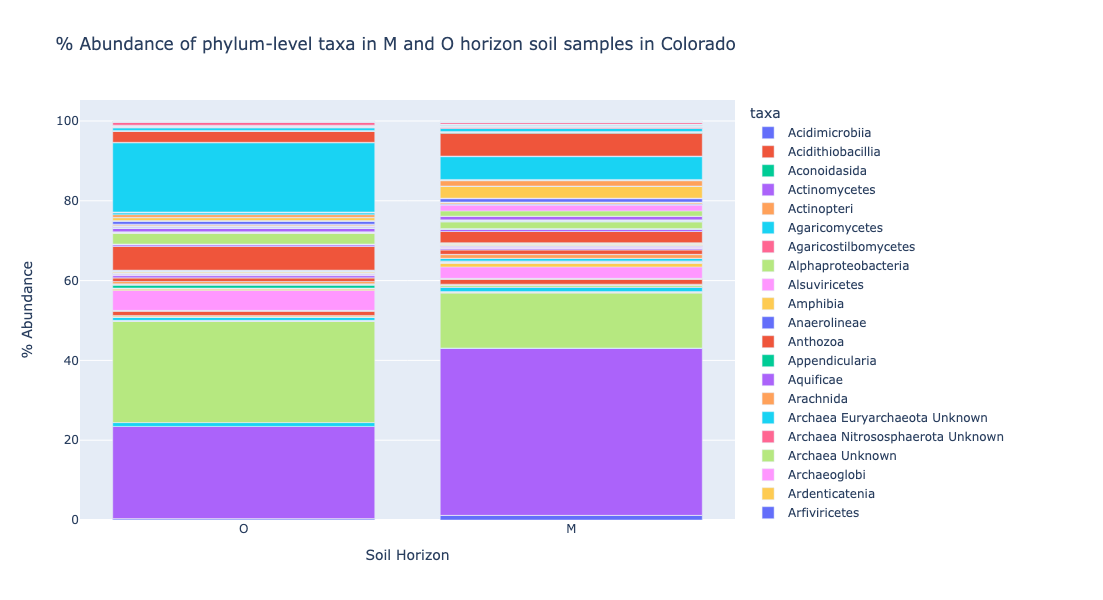

In [40]:
# Plot the taxa abundance of each soil type
fig = px.bar(abundance_df, x="soil_horizon", y="avg_relative_abundance", color="taxa", 
             title = "% Abundance of phylum-level taxa in M and O horizon soil samples in Colorado", 
             labels = {"soil_horizon": "Soil Horizon", "avg_relative_abundance": "% Abundance"})
    
fig.update_layout(height=600)
fig.show()          

## Write a function to calculate the abundance per location

This is a function to use with the `m_df` and `o_df` outputs from the TSV iteration to calculate the % abundance for each `geo_loc_name`. It also groups the taxa after the top 5 for each loaction into "other".

In [41]:
def loc_abund(df):

    # pivot the table to find all combos of biosample and taxa - set NAs to 0 for relative abundance
    wide_df = df.pivot(index = "biosample_id", columns = "taxa", values = "relative_abundance")
    wide_df = wide_df.fillna(0)
    wide_df.reset_index(inplace=True)

    # Add geo_loc_name column to wide_df
    wide_df = pd.merge(wide_df, df[['biosample_id', 'geo_loc_name']], on='biosample_id', how='left')
    
    # convert wide_df back with relative_abundances set to 0 for samples that were missing taxa
    melted_df = pd.melt(wide_df, id_vars=["biosample_id", "geo_loc_name"], var_name="taxa", value_name="relative_abundance")

    final_df = melted_df.groupby(["geo_loc_name", "taxa"])["relative_abundance"].mean().reset_index(name="avg_relative_abundance")

    return final_df

## Calculate the abundance of the location data frames

Using the function defined above, the `m_df` and the `o_df` data frames returned from iterating over the TSV files are used as input into the function, where the final abundance calculations and top 5 taxa are returned as data frames. We do the calculation by grouping by `geo_loc_name` in order to calculate abundances per location. We then concatenate the two data frames together, creating a new column for soil_horizon, where the value is either O or M, depending on which data frame it originally came from.

In [42]:
# caculate abundance for each soil horizon type and get top 5 taxa, grouping the rest
m_loc = loc_abund(m_df)
o_loc = loc_abund(o_df)

# combine data frames
o_loc["soil_horizon"] = "O"
m_loc["soil_horizon"] = "M"
loc_abund_df = pd.concat([o_loc, m_loc])

# Extract only region names from geo_loc_name
loc_abund_df["location"] = loc_abund_df["geo_loc_name"].str.extract(r'Colorado, (.*)')

loc_abund_df

,geo_loc_name,taxa,avg_relative_abundance,soil_horizon,location
0,"USA: Colorado, Niwot Ridge",Acidimicrobiia,0.372929,O,Niwot Ridge
1,"USA: Colorado, Niwot Ridge",Acidithiobacillia,0.032995,O,Niwot Ridge
2,"USA: Colorado, Niwot Ridge",Aconoidasida,0.002322,O,Niwot Ridge
3,"USA: Colorado, Niwot Ridge",Actinomycetes,26.706633,O,Niwot Ridge
4,"USA: Colorado, Niwot Ridge",Actinopteri,0.000910,O,Niwot Ridge
...,...,...,...,...,...
1259,"USA: Colorado, Rocky Mountains",unclassified candidate division Zixibacteria,0.015965,M,Rocky Mountains
1260,"USA: Colorado, Rocky Mountains","unclassified dsDNA viruses, no RNA stage",0.000000,M,Rocky Mountains
1261,"USA: Colorado, Rocky Mountains",unclassified phages,0.000000,M,Rocky Mountains
1262,"USA: Colorado, Rocky Mountains",unclassified ssDNA viruses,0.000000,M,Rocky Mountains


## Plot the taxa abundance of M and O horizon soil samples for each location

Using the plotly library, the percent abundance of the taxa is plotted as a bar chart for each geo location and faceted by soil horizon.

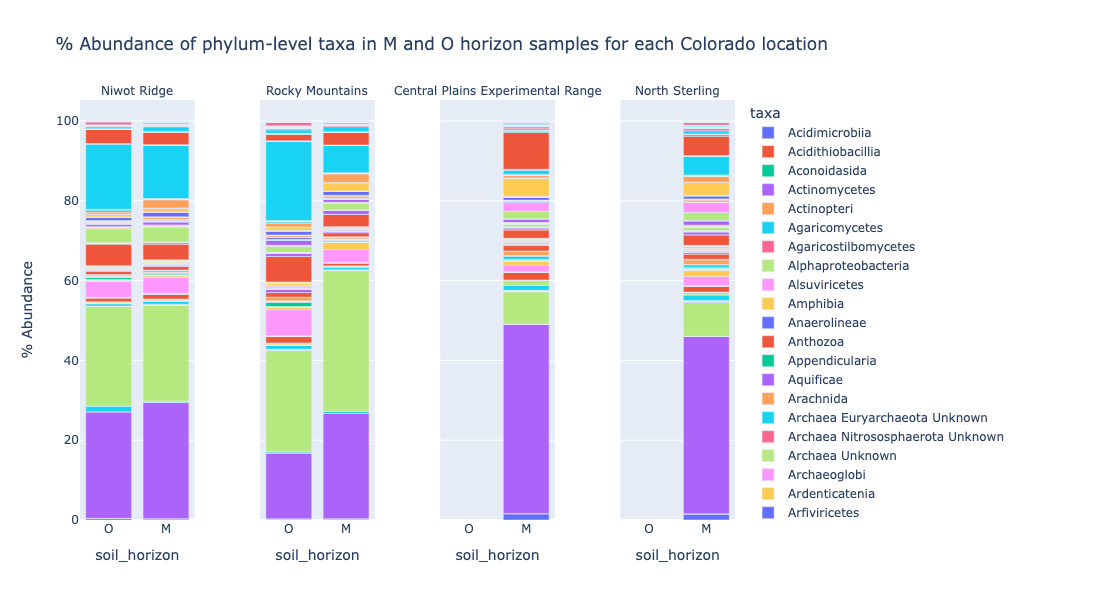

In [44]:
geo_fig = px.bar(loc_abund_df, x = "soil_horizon", y="avg_relative_abundance", color = "taxa", 
                 facet_col = "location",
                 facet_col_spacing = 0.1,
                 title = "% Abundance of phylum-level taxa in M and O horizon samples for each Colorado location", 
                 labels = {"geo_loc_name": "Location", "avg_relative_abundance": "% Abundance"},
                 height = 600)
# update figure to remove "location=" from facet column labels
geo_fig.for_each_annotation(lambda a: a.update(text=a.text.replace("location=", "")))

# show figure
geo_fig.show()

## Save as pickle file

Since this notebook takes a while to run, we can save the output and variables as a pickle file using the dill library. This will be in the `.gitignore` folder.

In [46]:
with open("contig_notebook_session.pkl", "wb") as f:
    dill.dump_session(f)

## Load the pickle file

When ready to load the pickle file run the cell below in a new jupyter session (uncomment):

In [ ]:
# with open("contig_notebook_session.pkl", "rb") as f:
#     loaded_data = dill.load(f)